In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0mvspd4u
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0mvspd4u
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 662 kB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 42 kB 984 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=464d62640bb22a72902e40b18fb055cd0bdf8e4d5d777ef1ad0f01196145c5b0
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31548 sha256=ebfdc06c74db8bf29a5448229566e875b6a61812283e00a36fafc086416f64b7
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
#load the train test data from my roboflow repo
#Access can be assigned if you contact us
!curl -L "https://app.roboflow.com/ds/uqN7oNUbT2?key=jRoW0ZAtEo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0    496      0  0:00:01  0:00:01 --:--:--   496
100 1403k  100 1403k    0     0   703k      0  0:00:01  0:00:01 --:--:--  703k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/110706_jpg.rf.7dfc53dc02e2e577cf51b0cab1f6a9d5.jpg  
 extracting: test/110722_jpg.rf.2c73075e0de7f2d3c5742817414a7694.jpg  
 extracting: test/110723_jpg.rf.c058864c01be2f122c191dfa14f1b30c.jpg  
 extracting: test/110724_jpg.rf.d5e2f577135890c8fd8469101e686f76.jpg  
 extracting: test/110725_jpg.rf.dcd959540c1fb85069ee0d50abe590e6.jpg  
 extracting: test/110727_jpg.rf.a138d5b0778a8bdc3495fd1c08b792a2.jpg  
 extracting: test/110730_jpg.rf.aafedeefb2f95009ad4b9bbb362f1eb4.jpg  
 extracting: test/110732_jpg.rf.a4bff6d1e0c9cd43891faddca229122e.jpg 

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [11/14 14:55:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/14 14:55:30 d2.data.datasets.coco]: Loaded 31 images in COCO format from /content/train/_annotations.coco.json


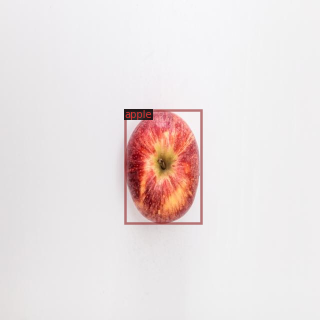

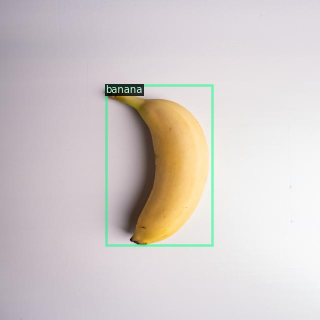

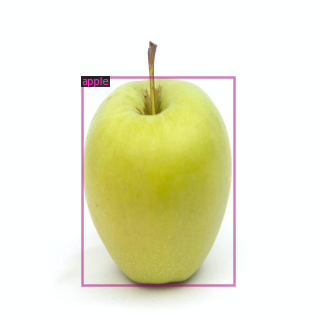

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# select a model from here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/14 14:55:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:04, 39.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/14 14:55:44 d2.engine.train_loop]: Starting training from iteration 0
[11/14 14:55:57 d2.utils.events]:  eta: 0:09:55  iter: 19  total_loss: 2.707  loss_cls: 1.735  loss_box_reg: 0.977  loss_rpn_cls: 0.003  loss_rpn_loc: 0.003  time: 0.6055  data_time: 0.0488  lr: 0.000020  max_mem: 3160M
[11/14 14:56:08 d2.utils.events]:  eta: 0:09:32  iter: 39  total_loss: 2.328  loss_cls: 1.333  loss_box_reg: 0.955  loss_rpn_cls: 0.003  loss_rpn_loc: 0.003  time: 0.5955  data_time: 0.0107  lr: 0.000040  max_mem: 3160M
[11/14 14:56:20 d2.utils.events]:  eta: 0:09:18  iter: 59  total_loss: 1.809  loss_cls: 0.863  loss_box_reg: 0.968  loss_rpn_cls: 0.004  loss_rpn_loc: 0.003  time: 0.5914  data_time: 0.0111  lr: 0.000060  max_mem: 3160M
[11/14 14:56:32 d2.utils.events]:  eta: 0:09:03  iter: 79  total_loss: 1.582  loss_cls: 0.645  loss_box_reg: 0.936  loss_rpn_cls: 0.002  loss_rpn_loc: 0.003  time: 0.5879  data_time: 0.0125  lr: 0.000080  max_mem: 3160M
[11/14 14:56:44 d2.utils.events]:  eta: 0:08:5

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/14 15:06:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/14 15:06:17 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/test/_annotations.coco.json
[11/14 15:06:17 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   object   | 0            |   apple    | 3            |   banana   | 3            |
|   bottle   | 3            |    mug     | 4            |            |              |
|   total    | 13           |            |              |            |              |
[11/14 15:06:17 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[11/14 15:06:17 d2.data.common]: Serialized dataset takes 0.00 MiB
[11/14 15:06:17 d2.evaluation.evaluator]: Start inference on 11 i

OrderedDict([('bbox',
              {'AP': 70.95297029702971,
               'AP50': 91.58415841584159,
               'AP75': 83.16831683168317,
               'APs': nan,
               'APm': nan,
               'APl': 70.95297029702971,
               'AP-object': nan,
               'AP-apple': 83.26732673267327,
               'AP-banana': 54.75247524752476,
               'AP-bottle': 73.26732673267327,
               'AP-mug': 72.52475247524752})])

In [ ]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/CEG5205/project/Detectron_weight/model_final.pth")
#cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/CEG5205/project/Detectron_weight/model_final.pth"

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  print(outputs)
  cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
im = cv2.imread("4444.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print(outputs)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:

cfg1 = get_cfg()
cfg1.MODEL.DEVICE = "cpu"
cfg1.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# cfg1.DATASETS.TRAIN = ("my_dataset_train",)
# cfg1.DATASETS.TEST = ("my_dataset_val",)

# cfg1.DATALOADER.NUM_WORKERS = 4
# cfg1.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# cfg1.SOLVER.IMS_PER_BATCH = 4
# cfg1.SOLVER.BASE_LR = 0.001


# cfg1.SOLVER.WARMUP_ITERS = 1000
# cfg1.SOLVER.MAX_ITER = 500
# cfg1.SOLVER.STEPS = (1000, 1500)
# cfg1.SOLVER.GAMMA = 0.05

cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 5 


cfg1.MODEL.WEIGHTS = "/content/drive/MyDrive/CEG5205/model_final.pth"

cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold
predictor = DefaultPredictor(cfg1)

im = cv2.imread("4444.jpeg")
outputs = predictor(im)
print(outputs)

In [ ]:
cfg1 = get_cfg()
cfg1.MODEL.DEVICE = "cpu"
cfg1.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 5 #your number of classes + 1


cfg1.MODEL.WEIGHTS = "/content/drive/MyDrive/CEG5205/model_final.pth"

cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg1)

im = cv2.imread("4444.jpeg")
outputs = predictor(im)

print(outputs)